# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Importing other necessary libraries 

import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

#import the warnings.
import warnings
warnings.simplefilter("ignore")

# Setting display to show all details
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1. Offer Portfolio Data

In [3]:
# Looking at sample data format for all 3 files shared with us
# starting with portfolio data

print(portfolio.head())
print('\n\n dimensions of dataset',portfolio.shape)
print('\n\n dimensions of dataset',portfolio.info())

display(portfolio.isnull().sum())

   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  


 dimensions of dataset (10, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     obje

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [4]:
portfolio.drop_duplicates

<bound method DataFrame.drop_duplicates of    reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  


In [5]:
# Splitting the channels to multiple columns and then creating encoding from them, joining to parent database
temp = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, temp], axis = 1)

# Encoding the Offer Type
temp1 = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, temp1], axis = 1)

# Dropping Channels and Offer Type from portfolio data 
portfolio = portfolio.drop(['channels', 'offer_type'], axis=1)
portfolio.head()

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [6]:
# Calculating Reward to Difficulty ratio for the offer + # of channels used for the offer
portfolio['Reward_Ratio'] = (portfolio['reward'] / portfolio['difficulty']).replace(np.nan, 0)
portfolio['Channel_count']= portfolio['email'] + portfolio['mobile'] + portfolio['social'] + portfolio['web']   
portfolio

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,1.000000,3
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,1.000000,4
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,0.000000,3
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,1.000000,3
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,0.250000,2
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,0.428571,4
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,0.200000,4
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,0.000000,3
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,1.000000,4
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,0.200000,3


### Listing Observations and Hypothesis around Portfolio data

1. There are 10 offer combinations shared in the data
2. Offers are shared across multiple channels with different 
3. There are no Null observations 
4. There are 4 offers utilizing all 4 channels, 5 offers using 3 channels and 1 using ony 2 channels
5. Email is the most popular channel for the offers and used across all offers
6. BOGO has 100% reward ratio with different level of difficulty


## 2. Customer Profile Data

In [7]:
# Looking at sample data format for all 3 files shared with us
# looking at profile data

print(profile.head())
print('\n\n dimensions of dataset', profile.shape)
print('\n\n dimensions of dataset', profile.info())

display(profile.isnull().sum())

  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN


 dimensions of dataset (17000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


 dime

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

### Listing Observations and Hypothesis around customer profile data

1. There is data available for 17,000 customers
2. Gender and income information is unavailable for 2,175 customers - need some kind of data cleaning + imputation 
3. There can be feature engineering be done on 'became_member_on' feature

In [8]:
profile.gender.value_counts()/len(profile)*100

M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64

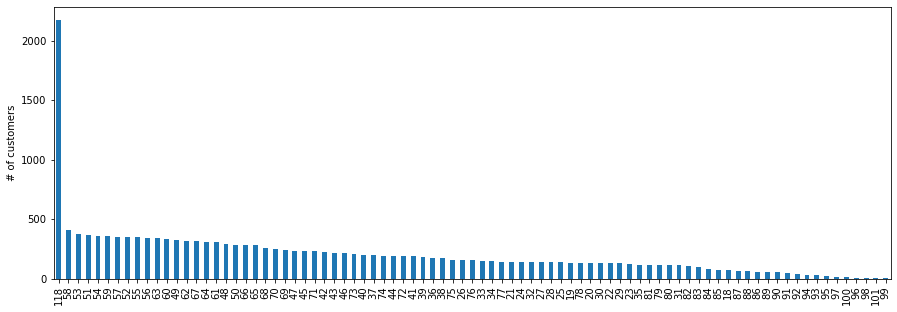

In [9]:
plt.figure(figsize=[15,5])
profile.age.value_counts().plot(kind='bar')
plt.ylabel('# of customers')
plt.show()

# Indicate that about 2100+ customers dont have age information captured as well

In [10]:
# Extracting Year and Month from the numerical format date in the dataframe
profile['join_year'] = (profile.became_member_on/10000).astype(int)
profile['join_month'] = (profile.became_member_on/100).astype(int) - (profile.became_member_on/10000).astype(int)*100
profile.head()

,gender,age,id,became_member_on,income,join_year,join_month
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017,7
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017,5
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017,8


In [11]:
# imputing income for the joining year mean income value

inc_avg = profile.groupby('join_year')['income'].mean().astype(int).reset_index(name = "avg_income")
profile = profile.merge(inc_avg, on = 'join_year')
profile['income'].fillna(profile.avg_income, inplace = True)
profile.drop(['avg_income', 'became_member_on'],axis =1,  inplace=True)
profile.head()

,gender,age,id,income,join_year,join_month
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,65685.0,2017,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
3,None,118,a03223e636434f42ac4c3df47e8bac43,65685.0,2017,8
4,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,65685.0,2017,9


In [12]:
# Imputing 

gen_mod = profile.groupby(['join_year', 'gender'])['gender'].count().reset_index(name = 'ctr')
# Overall every year M gender is more prevalant than F/O, hence imputing the gender with M only
profile['gender'].fillna('M', inplace = True)
profile.head()


,gender,age,id,income,join_year,join_month
0,M,118,68be06ca386d4c31939f3a4f0e3dd783,65685.0,2017,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
3,M,118,a03223e636434f42ac4c3df47e8bac43,65685.0,2017,8
4,M,118,8ec6ce2a7e7949b1bf142def7d0e0586,65685.0,2017,9


In [13]:
# looking at distribution for numerical features

profile.describe()


,age,income,join_year,join_month
count,17000.000000,17000.000000,17000.000000,17000.000000
mean,62.531412,65467.053824,2016.635000,6.683529
std,26.738580,20202.882542,1.177624,3.487098
min,18.000000,30000.000000,2013.000000,1.000000
25%,45.000000,51000.000000,2016.000000,4.000000
50%,58.000000,65685.000000,2017.000000,7.000000
75%,73.000000,76000.000000,2017.000000,10.000000
max,118.000000,120000.000000,2018.000000,12.000000


### Listing Observations around Profile data

1. A big chunk of customers joined in 2017, 2018
2. Average income of customer group is `$65k` 
3. Three genders M, F, O. M is the most common gender 
4. Average age of customers is 62 years with median being 58 years, indicating moderately high age audience

## 3. Transcript Data

In [14]:
# Looking at sample data format for all 3 files shared with us
# looking at Transcript data

print(transcript.head(2))
print('\n\n dimensions of dataset', transcript.shape)
print('\n\n dimensions of dataset', transcript.info())

display(transcript.isnull().sum())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  


 dimensions of dataset (306534, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


 dimensions of dataset None


person    0
event     0
value     0
time      0
dtype: int64

In [15]:
transcript.head(2)
transcript.event.value_counts()


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [16]:
dic = transcript[transcript['event']== 'offer viewed']['value'].head(1)
dic

# There is only reward associated with entries with "offer completed", otherwise there is just offer id

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
Name: value, dtype: object

In [17]:
# transcript['offer_id'] = transcript['event'].apply(lambda x: x.get('offer id'))
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
#Based on the data dictionary extracting the offer id + offer_id, reward and amount of transaction

def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del ret[column]
    else:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del ret[column]
    return ret

transcript_new = unpack(transcript, 'value')

transcript_new['offer id'].fillna(transcript_new['offer_id'], inplace = True)
# Pivoting up the event data for modelling and replacing " " with "_" in values, merging back with main dataframe
transcript_new['event'] = transcript_new['event'].str.replace(" ", "_")
a = pd.get_dummies(transcript_new.event)
transcript_new = pd.concat([transcript_new, a], axis = 1)

#Dropping not required columns
transcript_new.drop(['offer_id'], axis = 1, inplace = True)
transcript_new.tail()

,person,event,time,offer id,amount,reward,offer_completed,offer_received,offer_viewed,transaction
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,0,0,0,1
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,NaN,4.05,NaN,0,0,0,1


In [19]:
# converting time from hours to days
transcript_new['time'] = round(transcript_new['time']/24,0).astype(int)
transcript_new.head()

,person,event,time,offer id,amount,reward,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


## Merging the datasets into single datasource now

1. Joining Transcript_new and Profile at person and id level
2. Joining resultant from #1 with portfolio data at offer id level 

In [20]:
temp = transcript_new.merge(profile, left_on = 'person', right_on = 'id', how = 'left')
temp.drop('id', inplace =  True, axis = 1)
df_updated = temp.merge(portfolio, left_on = 'offer id', right_on = 'id', how = 'left')
df_updated.drop('id', inplace =  True, axis = 1)
df_updated.head()

,person,event,time,offer id,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0


In [21]:
df_updated.head()

,person,event,time,offer id,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0


In [22]:
def mapper(df, feature):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in df[feature]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        encoded.append(coded_dict[val])
    return encoded

df_updated['user_id'] = mapper(df_updated, 'person')
df_updated['offer_id'] = mapper(df_updated, 'offer id')

del df_updated['person']
del df_updated['offer id']

# show header
df_updated.head()

,event,time,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id
0,offer_received,0,NaN,NaN,0,1,0,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1
1,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2
2,offer_received,0,NaN,NaN,0,1,0,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3
3,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4
4,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5


In [23]:
df_updated.user_id.nunique()

17000

## The Database is merged now, we can build features, build EDA and setup model

In [24]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   event            306534 non-null  object 
 1   time             306534 non-null  int32  
 2   amount           138953 non-null  float64
 3   reward_x         33579 non-null   float64
 4   offer_completed  306534 non-null  uint8  
 5   offer_received   306534 non-null  uint8  
 6   offer_viewed     306534 non-null  uint8  
 7   transaction      306534 non-null  uint8  
 8   gender           306534 non-null  object 
 9   age              306534 non-null  int64  
 10  income           306534 non-null  float64
 11  join_year        306534 non-null  int32  
 12  join_month       306534 non-null  int32  
 13  reward_y         167581 non-null  float64
 14  difficulty       167581 non-null  float64
 15  duration         167581 non-null  float64
 16  email            167581 non-null  floa

## Adding hypotheses and granular summaries to be observed

1. Evaluate Offer Type - Gender - Event level trends
2. Evaluate Offer Type - Age Group - Event level trends
3. Evaluate Offer ID popularity by Age group & Gender & Income group


Let's start with some univariate distributions and assessments

In [25]:
df_updated['age_grp'] = pd.qcut(df_updated['age'], 3, labels=["Young", "Medium", "Old"])
df_updated['inc_grp'] = pd.qcut(df_updated['income'], 3, labels=["Low", "Medium", "High"])
df_updated.head()

,event,time,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp
0,offer_received,0,NaN,NaN,0,1,0,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High
1,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium
2,offer_received,0,NaN,NaN,0,1,0,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium
3,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4,Old,Medium
4,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5,Old,Medium


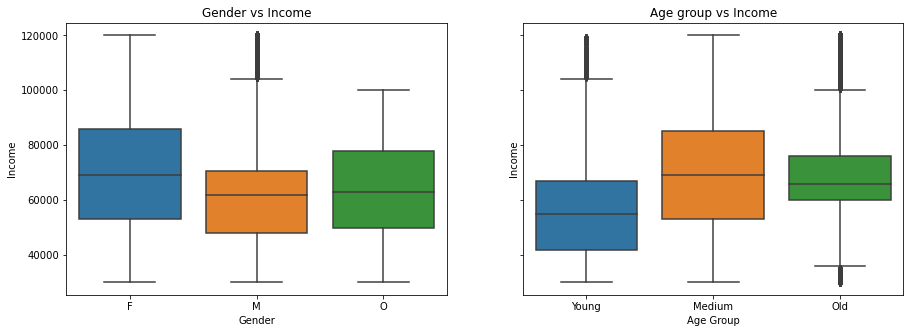

In [26]:
# Distributing Salary trends by Gender and age group 

fig, ax = plt.subplots(1,2,sharey=True,figsize=(15,5))
ax[0].set_title('Gender vs Income')

sns.boxplot(data=df_updated, x='gender', y='income', ax=ax[0])
ax[0].set(xlabel="Gender", ylabel = "Income")
ax[1].set_title('Age group vs Income')
sns.boxplot(data=df_updated, x='age_grp', y='income', ax=ax[1])
ax[1].set(xlabel="Age Group", ylabel = "Income")
plt.show()

### Observations

1. F gender median salary is higher than other genders
2. Medium age group median salary is higher tha other age groups

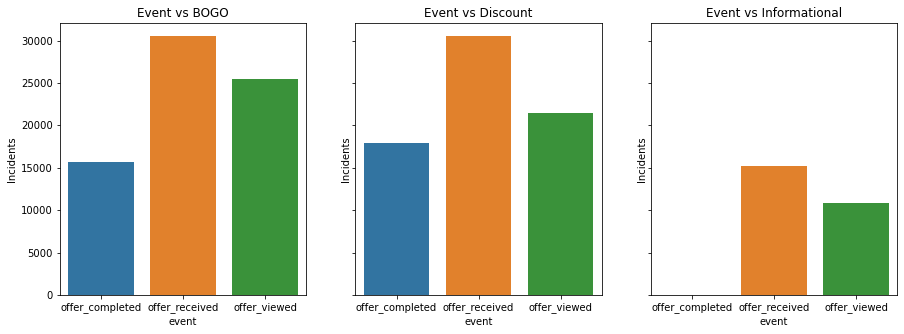

In [27]:
# Offer reception by type of offer

d1 = df_updated[df_updated['bogo']==1].groupby('event')['event'].count().reset_index(name = "BOGO_Incidents")
d1 = d1.merge(df_updated[df_updated['discount']==1].groupby('event')['event'].count().reset_index(name = "Dis_Incidents"), how = 'left')
d1 = d1.merge(df_updated[df_updated['informational']==1].groupby('event')['event'].count().reset_index(name = "Inf_Incidents"), how = 'left')

fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax[0].set_title('Event vs BOGO')

sns.barplot(data=d1, x='event', y='BOGO_Incidents', ax=ax[0])
ax[0].set(xlabel="event", ylabel = "Incidents")

ax[1].set_title('Event vs Discount')
sns.barplot(data=d1, x='event', y='Dis_Incidents', ax=ax[1])
ax[1].set(xlabel="event", ylabel = "Incidents")

ax[2].set_title('Event vs Informational')
sns.barplot(data=d1, x='event', y='Inf_Incidents', ax=ax[2])
ax[2].set(xlabel="event", ylabel = "Incidents")

plt.show()          

### Observations

1. BOGO Offer received to view rate is higher than Discount offer
2. Discount offers received to completion rate is higher than that of BOGO

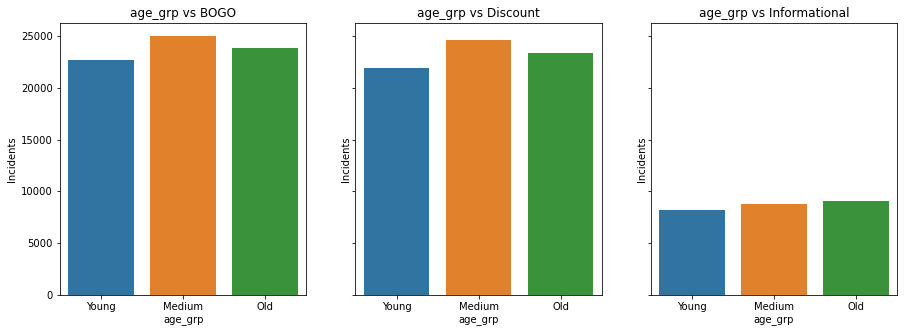

In [28]:
# Offer reception by Age group

d1 = df_updated[df_updated['bogo']==1].groupby('age_grp')['age_grp'].count().reset_index(name = "BOGO")
d1 = d1.merge(df_updated[df_updated['discount']==1].groupby('age_grp')['age_grp'].count().reset_index(name = "Discount"), how = 'left')
d1 = d1.merge(df_updated[df_updated['informational']==1].groupby('age_grp')['age_grp'].count().reset_index(name = "Informational"), how = 'left')

fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax[0].set_title('age_grp vs BOGO')

sns.barplot(data=d1, x='age_grp', y='BOGO', ax=ax[0])
ax[0].set(xlabel="age_grp", ylabel = "Incidents")

ax[1].set_title('age_grp vs Discount')
sns.barplot(data=d1, x='age_grp', y='Discount', ax=ax[1])
ax[1].set(xlabel="age_grp", ylabel = "Incidents")

ax[2].set_title('age_grp vs Informational')
sns.barplot(data=d1, x='age_grp', y='Informational', ax=ax[2])
ax[2].set(xlabel="age_grp", ylabel = "Incidents")

plt.show()

### Observations

1. There is no major difference between distribution of offer across age groups
2. Both BOGO and Discount offers have similar volume across age groups as well
3. Medium age group customers get highest volume of offers

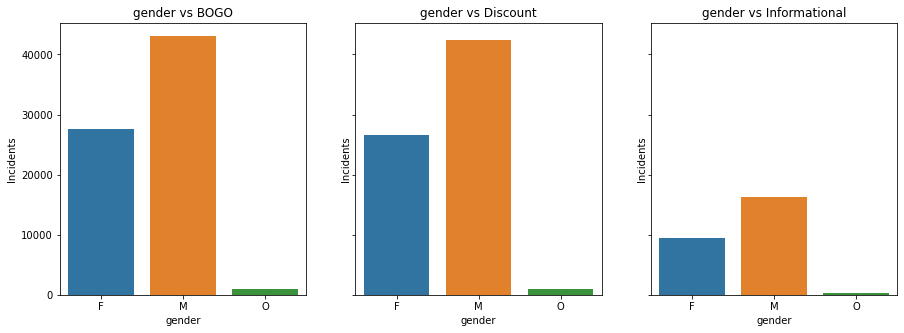

In [29]:
# Offer reception by Gender

d1 = df_updated[df_updated['bogo']==1].groupby('gender')['gender'].count().reset_index(name = "BOGO_Gender")
d1 = d1.merge(df_updated[df_updated['discount']==1].groupby('gender')['gender'].count().reset_index(name = "Dis_Gender"), how = 'left')
d1 = d1.merge(df_updated[df_updated['informational']==1].groupby('gender')['gender'].count().reset_index(name = "Inf_Gender"), how = 'left')

fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax[0].set_title('gender vs BOGO')

sns.barplot(data=d1, x='gender', y='BOGO_Gender', ax=ax[0])
ax[0].set(xlabel="gender", ylabel = "Incidents")

ax[1].set_title('gender vs Discount')
sns.barplot(data=d1, x='gender', y='Dis_Gender', ax=ax[1])
ax[1].set(xlabel="gender", ylabel = "Incidents")

ax[2].set_title('gender vs Informational')
sns.barplot(data=d1, x='gender', y='Inf_Gender', ax=ax[2])
ax[2].set(xlabel="gender", ylabel = "Incidents")

plt.show()

### Observations

1. There is no major difference between distribution of offer across genders
2. Both BOGO and Discount offers have similar volume across genders as well

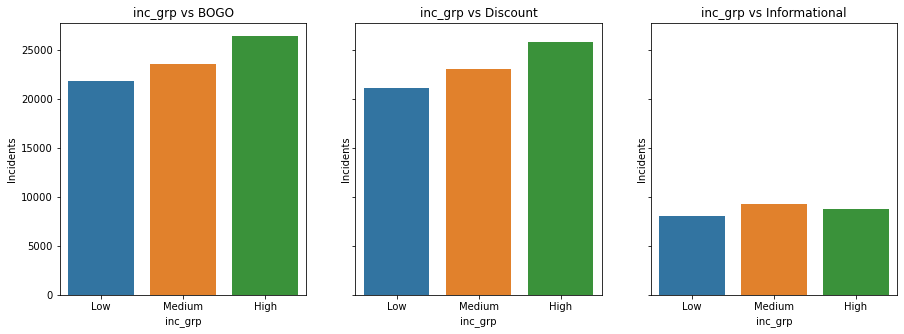

In [30]:
# Offer reception by Income group

d1 = df_updated[df_updated['bogo']==1].groupby('inc_grp')['inc_grp'].count().reset_index(name = "BOGO")
d1 = d1.merge(df_updated[df_updated['discount']==1].groupby('inc_grp')['inc_grp'].count().reset_index(name = "Discount"), how = 'left')
d1 = d1.merge(df_updated[df_updated['informational']==1].groupby('inc_grp')['inc_grp'].count().reset_index(name = "Informational"), how = 'left')

fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax[0].set_title('inc_grp vs BOGO')

sns.barplot(data=d1, x='inc_grp', y='BOGO', ax=ax[0])
ax[0].set(xlabel="inc_grp", ylabel = "Incidents")

ax[1].set_title('inc_grp vs Discount')
sns.barplot(data=d1, x='inc_grp', y='Discount', ax=ax[1])
ax[1].set(xlabel="inc_grp", ylabel = "Incidents")

ax[2].set_title('inc_grp vs Informational')
sns.barplot(data=d1, x='inc_grp', y='Informational', ax=ax[2])
ax[2].set(xlabel="inc_grp", ylabel = "Incidents")

plt.show()

### Observations

1. There is no major difference between distribution of offer across Income groups
2. Both BOGO and Discount offers have similar volume across Income groups as well
3. High income group customers get highest volume of both BOGO and Discount offers

In [31]:
# Observing trends by offer

d1 = df_updated.groupby(['offer_id', 'event'])['event'].count().reset_index(name = "Incidents")
# d1 = d1.merge(df_updated[df_updated['discount']==1].groupby('inc_grp')['inc_grp'].count().reset_index(name = "Discount"), how = 'left')
# d1 = d1.merge(df_updated[df_updated['informational']==1].groupby('inc_grp')['inc_grp'].count().reset_index(name = "Informational"), how = 'left')
d1 = d1.pivot(index='offer_id', columns='event', values='Incidents')
d1

event,offer_completed,offer_received,offer_viewed,transaction
offer_id,,,,
1,4354.0,7677.0,4171.0,NaN
2,3420.0,7668.0,2663.0,NaN
3,4017.0,7632.0,4118.0,NaN
4,5317.0,7597.0,7327.0,NaN
5,3331.0,7593.0,7298.0,NaN
6,4296.0,7571.0,7264.0,NaN
7,5156.0,7646.0,7337.0,NaN
8,NaN,7617.0,4144.0,NaN
9,3688.0,7658.0,6716.0,NaN


### Observation

1. Completion rates of Offer #4 & #7 is highest among all other offers
2. View rates of Offer #4, #5, #6, #7 is highest among all other offers

### Building a customer offer master database for modeling

In [32]:
df_updated.tail()

,event,time,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp
306529,transaction,30,1.59,NaN,0,0,0,1,M,66,47000.0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12620,11,Medium,Low
306530,transaction,30,9.53,NaN,0,0,0,1,M,52,62000.0,2018,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12624,11,Medium,Medium
306531,transaction,30,3.61,NaN,0,0,0,1,F,63,52000.0,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13099,11,Medium,Low
306532,transaction,30,3.53,NaN,0,0,0,1,M,57,40000.0,2016,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12640,11,Medium,Low
306533,transaction,30,4.05,NaN,0,0,0,1,M,118,67072.0,2015,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6233,11,Old,Medium


In [33]:
df_updated.shape

(306534, 29)

In [34]:
df_updated.user_id.nunique()

17000

In [35]:
df_updated[(df_updated['offer_completed']==1) & (df_updated['transaction']==1)].head()

,event,time,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp


In [36]:
# splitting dataframe to 

df_received = df_updated[(df_updated['event']=='offer_received')]
df_viewed = df_updated[(df_updated['event']=='offer_viewed')]
df_completed = df_updated[(df_updated['event']=='offer_completed')]

## Steps to setup

1. Keep received data as parent table and merge offer viewed df at customer offer level and keep only records where it is within send date + duration of the send date
2. Repeat same step for offer completed
3. Assign 1 vs 0 flag for completion
4. Scale the data and train a model

    4.1 Split it for BOGO vs BOGO50 vs Info
    
    4.2 Evaluate the max likliness of conversion for a customer for 


In [37]:
df_received.head()

,event,time,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp
0,offer_received,0,NaN,NaN,0,1,0,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High
1,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium
2,offer_received,0,NaN,NaN,0,1,0,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium
3,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4,Old,Medium
4,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5,Old,Medium


In [38]:
# s=df_viewed.groupby(['time', 'user_id', 'offer_id']).Button.apply(lambda x : (x!=x.shift()).cumsum())
# data.groupby([data.ID,s]).cumcount()+1

In [39]:
# Merging Offer Viewed data to the Offer received data to capture if given offer was viewed or not within offer validity time period

df_upd = df_received.merge(df_viewed[['time', 'user_id', 'offer_id', 'offer_viewed']] , 
                           left_on= ['user_id', 'offer_id'], right_on=['user_id', 'offer_id'])
df_upd['validity'] = df_upd['time_x']+ df_upd['duration']
df_upd = df_upd[(df_upd['validity']>=df_upd['time_y']) & (df_upd['time_y']>= df_upd['time_x'])]
df_upd.head()

,event,time_x,amount,reward_x,offer_completed,offer_received,offer_viewed_x,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp,time_y,offer_viewed_y,validity
0,offer_received,0,NaN,NaN,0,1,0,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High,0,1,7.0
1,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,0,1,10.0
4,offer_received,21,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,26,1,31.0
6,offer_received,24,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,26,1,34.0
7,offer_received,0,NaN,NaN,0,1,0,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium,1,1,7.0


In [40]:
# finding unique records that were viewed and left joining with offer received data, replacing NaN with 0

df_temp = df_upd[['user_id', 'offer_id', 'time_x', 'offer_viewed_y']].drop_duplicates()
df_view_rec = df_received.merge(df_temp, left_on= ['user_id', 'offer_id', 'time'], right_on=['user_id', 'offer_id', 'time_x'], how = 'left' )
df_view_rec['offer_viewed_y'] = df_view_rec['offer_viewed_y'].replace(np.nan, 0)
df_view_rec.head()                     

,event,time,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp,time_x,offer_viewed_y
0,offer_received,0,NaN,NaN,0,1,0,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High,0.0,1.0
1,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,0.0,1.0
2,offer_received,0,NaN,NaN,0,1,0,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium,0.0,1.0
3,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4,Old,Medium,0.0,1.0
4,offer_received,0,NaN,NaN,0,1,0,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5,Old,Medium,0.0,1.0


In [41]:
#Selecting only relevant columns

df_view_rec = df_view_rec[['event', 'time', 'gender', 'age', 'income', 'join_year', 'join_month', 'reward_y', 
                           'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 
                           'informational', 'Reward_Ratio', 'Channel_count', 'user_id', 'offer_id', 'age_grp', 
                           'inc_grp', 'offer_viewed_y']]
df_view_rec.head()

,event,time,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp,offer_viewed_y
0,offer_received,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High,1.0
1,offer_received,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,1.0
2,offer_received,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium,1.0
3,offer_received,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4,Old,Medium,1.0
4,offer_received,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5,Old,Medium,1.0


In [42]:
df_completed.head()

,event,time,amount,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp
12658,offer_completed,0,NaN,2.0,1,0,0,0,M,42,96000.0,2016,1,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.2,3.0,37,3,Young,High
12672,offer_completed,0,NaN,2.0,1,0,0,0,F,39,67000.0,2017,12,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.2,4.0,108,4,Young,Medium
12679,offer_completed,0,NaN,5.0,1,0,0,0,M,52,72000.0,2018,6,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,126,1,Medium,High
12692,offer_completed,0,NaN,10.0,1,0,0,0,M,37,92000.0,2017,5,10.0,10.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,36,9,Young,High
12697,offer_completed,0,NaN,10.0,1,0,0,0,M,48,62000.0,2015,9,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,228,5,Young,Medium


In [43]:
# Joining the Offer completion data with the offer received data

# Merging Offer Completed data to the Offer received data to capture if given offer was completed or not within offer validity time period

df_upd = df_view_rec.merge(df_completed[['time', 'user_id', 'offer_id', 'offer_completed']] , 
                           left_on= ['user_id', 'offer_id'], right_on=['user_id', 'offer_id'])
df_upd['validity'] = df_upd['time_x']+ df_upd['duration']
df_upd = df_upd[(df_upd['validity']>=df_upd['time_y']) & (df_upd['time_y']>= df_upd['time_x'])]
df_upd.head()


,event,time_x,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp,offer_viewed_y,time_y,offer_completed,validity
0,offer_received,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High,1.0,6,1,7.0
1,offer_received,0,M,65,53000.0,2018,2,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,6,6,Medium,Low,1.0,2,1,5.0
4,offer_received,21,M,65,53000.0,2018,2,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,6,6,Medium,Low,1.0,25,1,26.0
6,offer_received,21,M,64,100000.0,2017,9,10.0,10.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.00,3.0,13,9,Medium,High,1.0,21,1,28.0
7,offer_received,0,F,88,53000.0,2017,5,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,15,2,Old,Low,1.0,1,1,10.0


In [44]:
df_upd.shape

(35647, 27)

In [45]:
# finding unique records that were viewed and left joining with offer received data, replacing NaN with 0

df_temp = df_upd[['user_id', 'offer_id', 'time_x', 'offer_completed']].drop_duplicates()
df_view_rec_com = df_view_rec.merge(df_temp, left_on= ['user_id', 'offer_id', 'time'], right_on=['user_id', 'offer_id', 'time_x'], how = 'left' )
df_view_rec_com['offer_completed'] = df_view_rec_com['offer_completed'].replace(np.nan, 0)
df_view_rec_com.head()

,event,time,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp,offer_viewed_y,time_x,offer_completed
0,offer_received,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High,1.0,0.0,1.0
1,offer_received,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,1.0,NaN,0.0
2,offer_received,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium,1.0,NaN,0.0
3,offer_received,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4,Old,Medium,1.0,NaN,0.0
4,offer_received,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5,Old,Medium,1.0,NaN,0.0


In [46]:
df_view_rec_com.columns


Index(['event', 'time', 'gender', 'age', 'income', 'join_year', 'join_month',
       'reward_y', 'difficulty', 'duration', 'email', 'mobile', 'social',
       'web', 'bogo', 'discount', 'informational', 'Reward_Ratio',
       'Channel_count', 'user_id', 'offer_id', 'age_grp', 'inc_grp',
       'offer_viewed_y', 'time_x', 'offer_completed'],
      dtype='object')

In [55]:
df_view_rec_com['offer_viewed'] = df_view_rec_com['offer_viewed_y'].astype(int)
df_view_rec_com['offer_completed'] = df_view_rec_com['offer_completed'].astype(int)

df_view_rec_com.drop(['offer_viewed_y', 'time_x'], axis =1, inplace=True )

df_view_rec_com.head()

,event,time,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp,offer_completed,offer_viewed
0,offer_received,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High,1,1
1,offer_received,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,0,1
2,offer_received,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium,0,1
3,offer_received,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4,Old,Medium,0,1
4,offer_received,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5,Old,Medium,0,1


In [58]:
df_view_rec['inc_grp'].value_counts()

Medium    26153
High      25895
Low       24229
Name: inc_grp, dtype: int64

In [60]:
df_view_rec_com.head()

,event,time,gender,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,user_id,offer_id,age_grp,inc_grp,offer_completed,offer_viewed
0,offer_received,0,F,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,Old,High,1,1
1,offer_received,0,M,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,2,Old,Medium,0,1
2,offer_received,0,M,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,3,Old,Medium,0,1
3,offer_received,0,M,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,4,Old,Medium,0,1
4,offer_received,0,M,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,5,Old,Medium,0,1


In [64]:
df_view_rec_com = df_view_rec_com[['time', 'gender', 'age', 'income', 'join_year', 'join_month', 
                                   'reward_y', 'difficulty', 'duration', 'email', 'mobile', 'social',
                                   'web', 'bogo', 'discount', 'informational', 'Reward_Ratio',
                                   'Channel_count', 'user_id', 'offer_id', 'age_grp', 'inc_grp',
                                   'offer_viewed', 'offer_completed']]

# Creating dummy variables for the remaining categorical variables and dropping the original features

# Creating dummy variables for the variable 'Gender'
gen = pd.get_dummies(df_view_rec_com['gender'], prefix='Gen')
# Dropping Gender Page Submission column
gen1 = gen.drop(['Gen_O'], 1)
#Adding the results to the master dataframe
df_view_rec_com = pd.concat([df_view_rec_com,gen1], axis=1)


# Creating dummy variables for the variable 'age_grp'
gen1 = pd.get_dummies(df_view_rec_com['age_grp'], prefix='age')
# Dropping age_grp column
gen1 = gen1.drop(['age_Old'], 1)
#Adding the results to the master dataframe
df_view_rec_com = pd.concat([df_view_rec_com,gen1], axis=1)


# Creating dummy variables for the variable 'inc_grp'
gen1 = pd.get_dummies(df_view_rec_com['inc_grp'], prefix='inc')
# Dropping age_grp column
gen1 = gen1.drop(['inc_Low'], 1)
#Adding the results to the master dataframe
df_view_rec_com = pd.concat([df_view_rec_com,gen1], axis=1)

df_view_rec_com.drop(['gender', 'age_grp', 'inc_grp', 'user_id'], axis =1, inplace=True )

df_view_rec_com.head()

KeyError: "['gender', 'age_grp', 'inc_grp'] not in index"

In [67]:
df_view_rec_com.head()

,time,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,offer_id,offer_viewed,offer_completed,Gen_F,Gen_M,age_Young,age_Medium,inc_Medium,inc_High
0,0,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,1,1,0,0,0,0,1
1,0,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,1,0,0,1,0,0,1,0
2,0,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,1,0,0,1,0,0,1,0
3,0,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,1,0,0,1,0,0,1,0
4,0,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,1,0,0,1,0,0,1,0


### Train Test Split

In [68]:
# Putting feature variables to X

X = df_view_rec_com.drop(['offer_completed'],1)
X.head()

,time,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,offer_id,offer_viewed,Gen_F,Gen_M,age_Young,age_Medium,inc_Medium,inc_High
0,0,75,100000.0,2017,5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.00,3.0,1,1,1,0,0,0,0,1
1,0,118,65685.0,2017,8,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.25,2.0,2,1,0,1,0,0,1,0
2,0,68,70000.0,2018,4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.20,3.0,3,1,0,1,0,0,1,0
3,0,118,65685.0,2017,9,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.20,4.0,4,1,0,1,0,0,1,0
4,0,118,65685.0,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,4.0,5,1,0,1,0,0,1,0


In [69]:
y = df_view_rec_com['offer_completed']
y.head()

0    1
1    0
2    0
3    0
4    0
Name: offer_completed, dtype: int32

In [70]:
# Splitting the data into Train & Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

In [92]:
# Feature scaling for income
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[['income']] = scaler.fit_transform(X_train[['income']])
X_test[['income']] = scaler.transform(X_test[['income']])
X_train.head()

,time,age,income,join_year,join_month,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational,Reward_Ratio,Channel_count,offer_id,offer_viewed,Gen_F,Gen_M,age_Young,age_Medium,inc_Medium,inc_High
40004,17,51,-0.417422,2017,10,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.000000,4.0,5,1,0,1,0,1,1,0
43754,17,30,0.027278,2016,5,3.0,7.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.428571,4.0,7,1,1,0,1,0,1,0
6688,0,118,0.011714,2017,3,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.200000,3.0,3,0,0,1,0,0,1,0
74869,24,118,-0.177630,2018,3,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.000000,3.0,1,0,0,1,0,0,1,0
43329,17,57,0.076689,2016,6,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000,3.0,8,1,0,1,0,1,1,0


In [93]:
# Checking the Conversion Rate
print(y_train.mean())
print(y_test.mean())

0.4432790815275411
0.43882188428596397


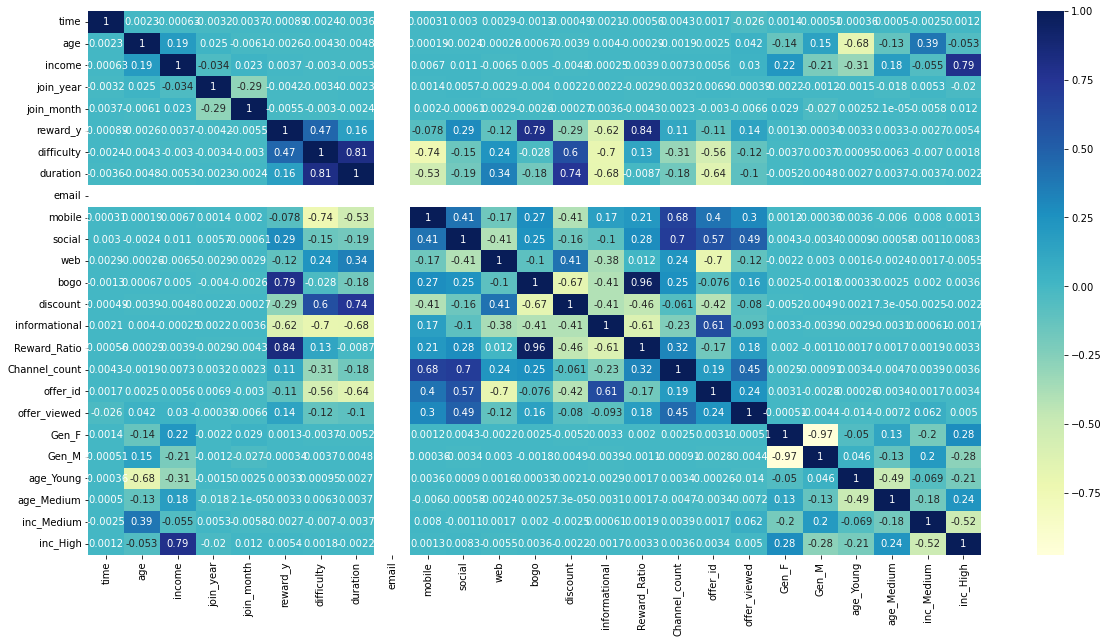

In [94]:
# Correlation plot to understand correlated features
plt.figure(figsize = (20,10))
sns.heatmap (X_train.corr(), annot = True, cmap = 'YlGnBu')
plt.show()

### Correlation Plot Summary

- A few features have really high correlation between them. For ex: BOGO vs Reward Ratio, Reward Ratio vs Reward value etc. We can remove Reward ratio from the feature list
- inc_High shows high correlation with income, only one of them can be used for modelling purpose

# Modelling on the features for predicting likliness of completion on a given offer


- Start with simple models linear model - Logistic regression to evaluate how features are impacting the offer completion
- Move to slightly complex models with Bagging and Boosting - Random Forest Classifier and XGBoost

In [105]:
# Logistic regression model with statsmodel

import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        offer_completed   No. Observations:                53393
Model:                            GLM   Df Residuals:                    53371
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23824.
Date:                Wed, 19 Oct 2022   Deviance:                       47648.
Time:                        00:18:13   Pearson chi2:                 4.26e+04
No. Iterations:                    28                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
time              0.0152      0.001     11.149      0.000       0.013       0.018
age              -0.0314      0.001    -33.702      0.000      -0.033      -0.030
income            0.3374      0.026     13.106      0.000       0.287       0.388
join_year        -0.4293      0.010    -41.373      0.000      -0.450      -0.409
join_month       -0.0311      0.003     -9.276      0.000      -0.038      -0.025
reward_y        -14.4338   1211.779     -0.012      0.990   -2389.478    2360.610
difficulty       14.3005    509.750      0.028      0.978    -984.792    1013.393
duration          0.1657   2832.092   5.85e-05      1.000   -5550.633    5550.965
email           364.4169   2.77e+04      0.013      0.990    -5.4e+04    5.47e+04
mobile           -6.2614   6998.164     -0.001      0.999   -1.37e+04    1.37e+04
social         -119.4263   7806.340     -0.015      0.988   -1.54e+04    1.52e+04
web            -119.3460   2.41e+04     -0.005      0.996   -4.74e+04    4.71e+04
bogo             18.2796   4308.155      0.004      0.997   -8425.549    8462.108
discount        105.4846   1.46e+04      0.007      0.994   -2.85e+04    2.88e+04
informational   240.6526   1.93e+04      0.012      0.990   -3.75e+04     3.8e+04
Reward_Ratio    252.7614   2.12e+04      0.012      0.990   -4.13e+04    4.18e+04
Channel_count   119.3833   4357.075      0.027      0.978   -8420.327    8659.093
offer_id         -0.0127   3540.115  -3.57e-06      1.000   -6938.511    6938.486
offer_viewed      1.0354      0.032     32.178      0.000       0.972       1.098
Gen_F            -0.0782      0.107     -0.730      0.465      -0.288       0.132
Gen_M            -0.8265      0.106     -7.781      0.000      -1.035      -0.618
age_Young        -1.0885      0.056    -19.436      0.000      -1.198      -0.979
age_Medium       -0.3301      0.039     -8.441      0.000      -0.407      -0.253
inc_Medium       -0.0934      0.038     -2.439      0.015      -0.168      -0.018
inc_High          0.3082      0.061      5.063      0.000       0.189       0.428
=================================================================================
"""

### There are a lot of features with high P-value and can be cleaned up with feature selection however, for this exercise we will proceed ahead with ensemble classifiers

### Trying Random Forest with some metrics to capture performance

In [96]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_train_rf_pred = rf.predict(X_train)
y_test_rf_pred = rf.predict(X_test)

print('Confusion Matrix on Train Data: \n', metrics.confusion_matrix(y_train, y_train_rf_pred))
print('Confusion Matrix on Test Data: \n', metrics.confusion_matrix(y_test, y_test_rf_pred))
print('Recall %:', metrics.recall_score(y_test, y_test_rf_pred)*100)
print('Precision %:', metrics.precision_score(y_test, y_test_rf_pred)*100)

Confusion Matrix on Train Data: 
 [[29591   134]
 [  397 23271]]
Confusion Matrix on Test Data: 
 [[8745 4097]
 [1525 8517]]
Recall %: 84.81378211511651
Precision %: 67.52021563342318


In [97]:
# Using Random Forest with Grid Search for hyperparameter tuning and Cross validation

rf_params = {'max_depth': [3, 5, 7],
             'min_samples_leaf': [5, 10, 50],
            'n_estimators': [50, 75, 100, 200]}

rf_grid = GridSearchCV(estimator= rf, param_grid=rf_params, cv=4, verbose=1, scoring='accuracy')

rf_grid.fit(X_train, y_train)

rf_params_cv = pd.DataFrame(rf_grid.cv_results_)
rf_params_cv.head()

Fitting 4 folds for each of 36 candidates, totalling 144 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.455727,0.019147,0.042933,0.002972,3,5,50,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est...",0.753689,0.769029,0.771651,0.752547,0.761729,0.008670,36
1,0.672081,0.013394,0.051220,0.001646,3,5,75,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est...",0.764402,0.773299,0.765957,0.757417,0.765269,0.005643,28
2,0.878014,0.016234,0.067762,0.004152,3,5,100,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est...",0.760806,0.769778,0.761987,0.760414,0.763246,0.003815,34
3,1.767093,0.048643,0.142123,0.008444,3,5,200,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est...",0.762454,0.767980,0.772101,0.761987,0.766130,0.004176,26
4,0.627434,0.128718,0.053334,0.013159,3,10,50,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",0.771743,0.761088,0.765133,0.758616,0.764145,0.004966,30


In [98]:
rf_grid.best_score_

0.7872755126862885

In [99]:
rf_grid.best_estimator_

RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_estimators=200)

### Best Score of 78.2% accuracy is observed with a RFC of max depth = 7 layers, min sample per leaf = 10 and # of trees = 200

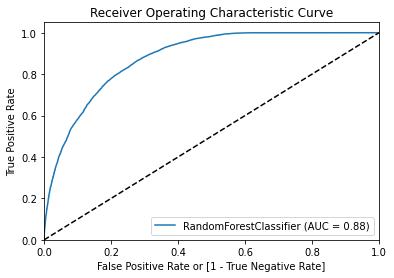

0.7861892008315697
Confusion Matrix on Train Data: 
 [[22260  7465]
 [ 3951 19717]]
Confusion Matrix on Test Data: 
 [[8030 4812]
 [ 706 9336]]
Recall %: 92.96952798247361
Precision %: 65.98812553011027


In [106]:
# Plotting ROC curve for best estimator. AUC observed - 88%

rf1 = RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_estimators=200, random_state=100)
rf1.fit(X_train, y_train)
y_train_rf1_pred = rf1.predict(X_train)
y_test_rf1_pred = rf1.predict(X_test)

from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf1, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

print(metrics.accuracy_score(y_train, y_train_rf1_pred))

print('Confusion Matrix on Train Data: \n', metrics.confusion_matrix(y_train, y_train_rf1_pred))
print('Confusion Matrix on Test Data: \n', metrics.confusion_matrix(y_test, y_test_rf1_pred))
print('Recall %:', metrics.recall_score(y_test, y_test_rf1_pred)*100)
print('Precision %:', metrics.precision_score(y_test, y_test_rf1_pred)*100)

### RFC provides a Test Recall and Precision of 93% and 66% respectively

### Trying with XGBoost to see if we get better results

In [107]:
# Trying Boosting 

xgbc = xgb.XGBClassifier(random_state=100, n_estimators=100)
xgbc.fit(X_train, y_train)
y_test_xgb_pred = xgbc.predict(X_test)
y_train_xgb_pred = xgbc.predict(X_train)

print(metrics.accuracy_score(y_train, y_train_xgb_pred))

print('Confusion Matrix on Train Data: \n', metrics.confusion_matrix(y_train, y_train_xgb_pred))
print('Confusion Matrix on Test Data: \n', metrics.confusion_matrix(y_test, y_test_xgb_pred))
print('Recall %:', metrics.recall_score(y_test, y_test_xgb_pred)*100)
print('Precision %:', metrics.precision_score(y_test, y_test_xgb_pred)*100)

[00:30:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8479388683909875
Confusion Matrix on Train Data: 
 [[25306  4419]
 [ 3700 19968]]
Confusion Matrix on Test Data: 
 [[6826 6016]
 [1026 9016]]
Recall %: 89.78291177056363
Precision %: 59.97871208089409


In [103]:
# Given sub-optimal results compared to RFC model, trying Grid Search + CV with XGBoost

xgb_params = {'learning_rate': [0.25, 0.5, 1, 10],
              'subsample': [0.5, 0.4, 0.3],
              'max_depth': [2,5,10]}

xgb_grid = GridSearchCV(estimator=xgbc, 
                        param_grid=xgb_params,
                        n_jobs=-1,
                        scoring='roc_auc',
                        return_train_score=True,
                        verbose=1,
                        cv=4
                       )
xgb_grid.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[00:18:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=100, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                      

In [110]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

[00:37:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.802427284475493
Confusion Matrix on Train Data: 
 [[23723  6002]
 [ 4547 19121]]
Confusion Matrix on Test Data: 
 [[7619 5223]
 [ 813 9229]]
Recall %: 91.90400318661621
Precision %: 63.85967340160531


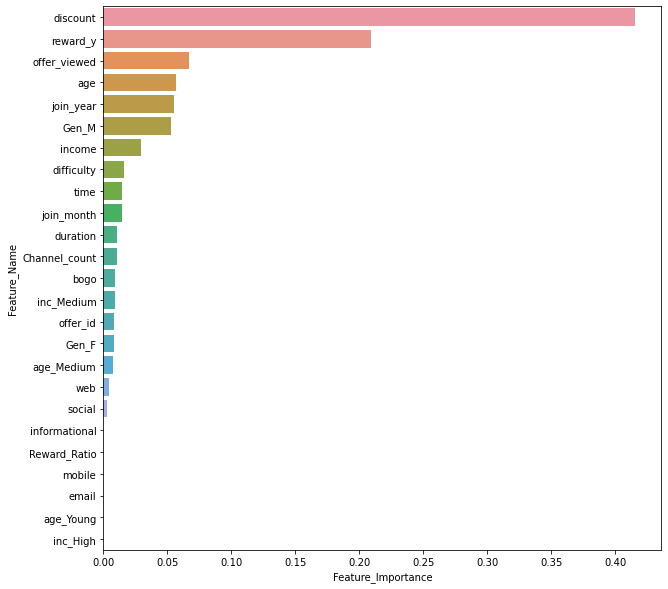

In [111]:
# From Grid Search picking best estimator and calculating evaluation metrics for the same
xgbc = xgb.XGBClassifier(random_state=100, n_estimators=100, max_depth=2, subsample=0.5, learning_rate=0.5)
xgbc.fit(X_train, y_train)
y_test_xgb_pred = xgbc.predict(X_test)
y_train_xgb_pred = xgbc.predict(X_train)

print(metrics.accuracy_score(y_train, y_train_xgb_pred))

print('Confusion Matrix on Train Data: \n', metrics.confusion_matrix(y_train, y_train_xgb_pred))
print('Confusion Matrix on Test Data: \n', metrics.confusion_matrix(y_test, y_test_xgb_pred))
print('Recall %:', metrics.recall_score(y_test, y_test_xgb_pred)*100)
print('Precision %:', metrics.precision_score(y_test, y_test_xgb_pred)*100)


# feature importance
imp = pd.DataFrame(columns=['Feature_Name', 'Feature_Importance'])
imp['Feature_Name'] = X_train.columns
imp['Feature_Importance'] = xgbc.feature_importances_
imp.sort_values(by = 'Feature_Importance', ascending = False, inplace=True)

plt.figure(figsize=[10,10])
sns.barplot(data = imp, y= 'Feature_Name', x= 'Feature_Importance')
plt.show()

### Overall discount and total reward value is one of the biggest factors indicating offer completion. This correlates with general understanding around higher the reward value higher the conversion

### The Random Forest Classifier performs the best with overall ~80% accuracy to predict if a offer shared is likely to be completed or not within the valid duration. We will be using that for final predictions